In [13]:
import gym
from helpers import NormalizedEnv, RandomAgent
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from mpl_toolkits.mplot3d import Axes3D
from pylab import*
import os

## 3. Heuristic Policy

In [2]:
# Implement a heuristic policy
class HeuristicPendulumAgent():
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='HeuristicPendulumAgent'

    def get_agent_name(self):
        return self.agent_name

    def compute_action(self, state,fix_torque=0.1):
         # When the pendulum is in the lower half of the domain (x<0)
         if state[0]<0:
             # applies a fixed torque in the same direction as the pendulum’s angular velocity
             return fix_torque*np.sign(state[2])
         # When the pendulum is in the higher half of the domain (x>0)
         else:
             # applies a fixed torque in the  opposite direction as the pendulum’s angular velocity
             return -1*fix_torque*np.sign(state[2])

In [3]:
def DoState(env,agent,observation,total_reward_per_episode,agent_name='RandomAgent',fix_torque=0.1):
    if agent_name=='HeuristicPendulumAgent':
        action = agent.compute_action(observation,fix_torque)
    else:
        action = agent.compute_action(observation)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    observation, reward, terminated, truncated, info = env.step(normalized_action)
    # print('observation:',observation)
    # print('reward:',reward)
    # print('terminated:',terminated)
    total_reward_per_episode += reward
    # print('total_reward:',total_reward)
    if terminated or truncated:
        observation, info = env.reset()

    return observation, info, total_reward_per_episode

def DoEpisode(env,agent,agent_name='RandomAgent',fix_torque=0.1,num_state=200) :
    observation, info = env.reset()
    total_reward_per_episode=0
    for _ in range(num_state):
        observation, info, total_reward_per_episode=DoState(env,agent,observation,total_reward_per_episode,agent_name,fix_torque)
        # print("total_reward_per_episode:",total_reward_per_episode)
    return total_reward_per_episode

c:\Users\CHANGCHUNTZU\PycharmProjects\CS456-DDPG\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


total_reward: -1311.4019686061474
average_reward: -1311.4019686061474
total_reward: -2636.4940111855185
average_reward: -1318.2470055927593
total_reward: -3978.4378299629425
average_reward: -1326.145943320981
total_reward: -5049.2966757403
average_reward: -1262.324168935075
total_reward: -6233.355242634377
average_reward: -1246.6710485268754
total_reward: -7482.300325815202
average_reward: -1247.0500543025337
total_reward: -8870.0856233384
average_reward: -1267.155089048343
total_reward: -9731.109872196886
average_reward: -1216.3887340246108
total_reward: -10357.472310963278
average_reward: -1150.8302567736976
total_reward: -11592.831877782657
average_reward: -1159.2831877782658
total_reward: -1072.9808169369198
average_reward: -1072.9808169369198
total_reward: -2660.3893445483436
average_reward: -1330.1946722741718
total_reward: -4215.953390759074
average_reward: -1405.3177969196913
total_reward: -5280.6905230212
average_reward: -1320.1726307553
total_reward: -6609.74910084531
average

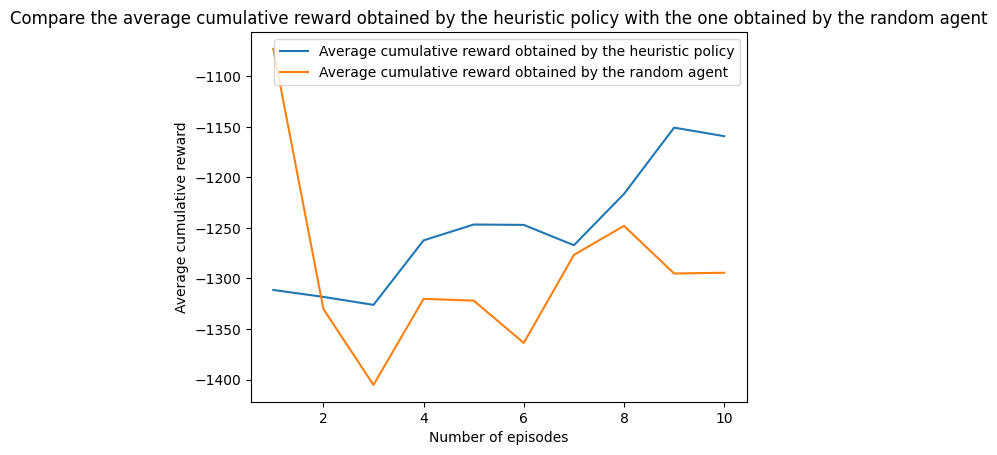

In [4]:
env = gym.make("Pendulum-v1")
num_episode=10
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to compare the average cumulative reward obtained by the heuristic policy 
# with the reward of the random agent
list_average_reward_HeuristicAgent=[]
total_episodes_reward_HeuristicAgent = 0
for episode in range(num_episode):
    agent = HeuristicPendulumAgent(env)
    total_reward_per_episode=DoEpisode(env, agent,agent.get_agent_name())
    total_episodes_reward_HeuristicAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_HeuristicAgent)
    average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_HeuristicAgent.append(average_reward)

list_average_reward_RandomAgent=[]
total_episodes_reward_RandomAgent = 0
for episode in range(num_episode):
    agent = RandomAgent(env)
    total_reward_per_episode=DoEpisode(env, agent)
    total_episodes_reward_RandomAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_RandomAgent)
    average_reward = total_episodes_reward_RandomAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_RandomAgent.append(average_reward)

list_number_episodes = np.linspace(1,10,num=10)

plt.plot(list_number_episodes,list_average_reward_HeuristicAgent,label= 'Average cumulative reward obtained by the heuristic policy')
plt.plot(list_number_episodes,list_average_reward_RandomAgent,label= 'Average cumulative reward obtained by the random agent')
plt.xlabel('Number of episodes')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.title('Compare the average cumulative reward obtained by the heuristic policy with the one obtained by the random agent')
plt.show()
env.close()

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
total_reward: -1192.070913095692
average_reward: -1192.070913095692
total_reward: -2647.7760545402853
average_reward: -1323.8880272701426
total_reward: -3581.8938960636597
average_reward: -1193.9646320212198
total_reward: -5124.734006450233
average_reward: -1281.1835016125583
total_reward: -6179.601530521433
average_reward: -1235.9203061042867
total_reward: -7254.43230604871
average_reward: -1209.0720510081185
total_reward: -8119.506000909355
average_reward: -1159.9294287013365
total_reward: -9184.187360922651
average_reward: -1148.0234201153314
total_reward: -9814.70990349969
average_reward: -1090.5233226110768
total_reward: -10568.76747138172
average_reward: -1056.876747138172
total_reward: -253.04871453621323
average_reward: -253.04871453621323
total_reward: -508.96419737907513
average_reward: -254.48209868953757
total_reward: -1600.573983169711
average_reward: -533.5246610565704
total_reward: -1978.9

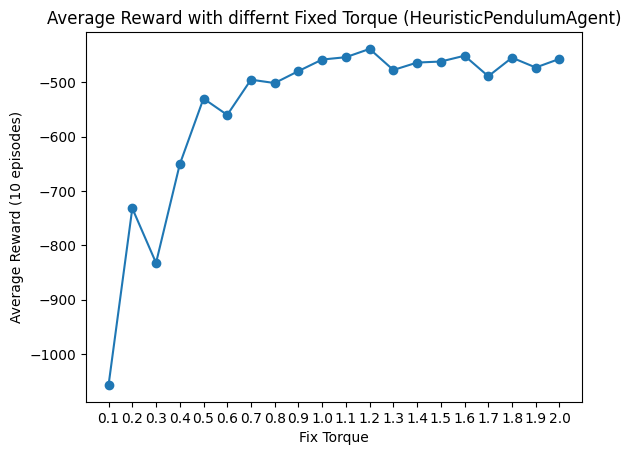

In [5]:
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to show the impact of different amplitude of the fixed torque have on the reward
env = gym.make("Pendulum-v1")
num_episode=10
list_last_average_reward=[]
list_fix_torque=np.linspace(0.1, 2.0, num=20)
print(list_fix_torque)
for fix_torque in list_fix_torque:
    total_episodes_reward_HeuristicAgent=0
    for episode in range(num_episode):
        agent = HeuristicPendulumAgent(env)
        total_reward_per_episode=DoEpisode(env,agent,agent.get_agent_name(),fix_torque)
        total_episodes_reward_HeuristicAgent += total_reward_per_episode
        print('total_reward:', total_episodes_reward_HeuristicAgent)
        average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
        print('average_reward:', average_reward)
    list_last_average_reward.append(average_reward)
plt.plot(list_fix_torque,list_last_average_reward,'-o')
plt.xlabel("Fix Torque")
plt.ylabel("Average Reward (10 episodes)")
plt.title('Average Reward with differnt Fixed Torque (HeuristicPendulumAgent)')
plt.xticks(list_fix_torque)
plt.show()
env.close()

In [6]:
import gym
env = gym.make("Pendulum-v1")
observation, info = env.reset(seed=42)

for _ in range(10):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print('observation:',observation)
    print('reward:',reward)
    print(np.append(observation,reward))
    if terminated or truncated:
        observation, info = env.reset()
env.close()

observation: [-0.17824942  0.98398536  0.573736  ]
reward: -2.964517417338722
[-0.17824942  0.98398536  0.57373601 -2.96451742]
observation: [-0.23214817  0.97268045  1.1015704 ]
reward: -3.0973921534663664
[-0.23214817  0.97268045  1.10157037 -3.09739215]
observation: [-0.3120608   0.95006216  1.6615154 ]
reward: -3.380944420302668
[-0.3120608   0.95006216  1.66151536 -3.38094442]
observation: [-0.41112214  0.91158026  2.1264665 ]
reward: -3.843927441987944
[-0.41112214  0.91158026  2.12646651 -3.84392744]
observation: [-0.54468435  0.83864117  3.0465596 ]
reward: -4.432624458895667
[-0.54468435  0.83864117  3.04655957 -4.43262446]
observation: [-0.69918066  0.7149451   3.9647624 ]
reward: -5.540659141180263
[-0.69918066  0.71494508  3.96476245 -5.54065914]
observation: [-0.8419852   0.53950053  4.5340343 ]
reward: -7.071228852679368
[-0.84198523  0.53950053  4.53403425 -7.07122885]
observation: [-0.9473544   0.32018688  4.8783417 ]
reward: -8.66980046938454
[-0.94735438  0.32018688  

## 4. Q function of the heuristic policy 

In [19]:
import random
# Implement the Replay Buffer
class ReplayBuffer():
    def __init__(self, max_size):
        # max_size: how many transitions replay buffer can store at most
        self.max_size = max_size
        self.total_transition = []

    def add(self, transition):
        # transition: a tuple of (state, action, reward, next_state, trunc)

        # check if the replay buffer is full
        if len(self.total_transition) >= self.max_size:
            # print("The replay buffer is full.-> remove the oldest transition")
            # remove the oldest transition
            self.total_transition.pop(0)
        # add transition to replay buffer
        self.total_transition.append(transition)
        
    def sample(self, batch_size):
        # batch_size: how many transitions will be sampled
        # return a batch of transitions
        
        # check if the replay buffer is empty
        if len(self.total_transition) == 0:
            print("The replay buffer is empty.")
            return None
        
        # check if the replay buffer has enough transitions
        if len(self.total_transition) < batch_size:
            print("The replay buffer does not have enough transitions.")
            return None
        
        # sample batch_size transitions from the replay buffer randomly
        return random.sample(self.total_transition, batch_size)

In [20]:
# Implement the class QNetwork
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=1, hidden_dim=32):
        super(QNetwork, self).__init__()
        # input_dim: dimension of the input -> 3 elements of the state and 1 of the action
        # hidden_dim: dimension of one hidden layer -> 32 nodes
        # output_dim: dimension of action -> a scalar value (the expected cumulative reward)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        # state: state -> 3 elements of the state and 1 of the action
        # return expected cumulative reward 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

In [42]:
# Implement the 1-step TD-learning rule for the QNetwork
def train(Q_network, Q_target,agent, replay_buffer, gamma, optimizer, batch_size,fix_torque=0.1):
    # print("HERE TRAIN")
    # Q_network: Q Network
    # Q_target: target Q network
    # agent: policy use for action selection
    # replay_buffer: replay buffer
    # gamma: discount factor
    # optimizer: optimizer
    # batch_size: batch size
    # fix_torque: fixed torque for HeuristicPendulumAgent
    
    # sample a batch of transitions from the replay buffer
    batch = replay_buffer.sample(batch_size)
    
    # unpack the batch of transitions
    # input_batch:put together 3 elements of the state and 1 of the action
    input_batch=torch.tensor([np.append(transition[0],transition[1]) for transition in batch], dtype=torch.float32)
    action_batch=torch.tensor([transition[1] for transition in batch], dtype=torch.float32)
    reward_batch = torch.tensor([transition[2] for transition in batch], dtype=torch.float32)
    target_batch=torch.tensor([np.append(transition[3], agent.compute_action(transition[3],fix_torque)) for transition in batch], dtype=torch.float32)
    next_state_batch = torch.tensor([transition[3] for transition in batch], dtype=torch.float32)
    trunc_batch = torch.tensor([transition[4] for transition in batch], dtype=torch.float32)

    # clear the gradients of the optimizer
    optimizer.zero_grad()

    # compute the Q values of the current state + action pair
    Q_values = Q_network(input_batch)
    
    # The target should not be differentiated, i.e., wrap it in a with torch.no grad()
    ## Todo: check with TA if it is correct
    with torch.no_grad():
        # compute the Q values of the next state + action pair
        Q_next_values = Q_target(target_batch)
        # compute the target Q values
        Q_target_values = reward_batch + gamma * Q_next_values.max(1)[0] * (1 - trunc_batch)
        
    
    # compute the loss
    loss = F.mse_loss(Q_values.view(-1, 1), Q_target_values.view(-1, 1))
    
    
    # compute the gradients of the loss
    loss.backward()
    # # show the gradients of the parameters in the Q network
    print("Q_network:",Q_network.fc1.weight.grad[0])
    try:
        print("Q_target:",Q_target.fc1.weight.grad[0])
    except:
        pass
    
    # update the weights of the Q network
    optimizer.step()
    
    return loss.item()

c:\Users\CHANGCHUNTZU\PycharmProjects\CS456-DDPG\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode number: 0 / 20 ...
Q_network: tensor([-0.0028, -0.0086, -0.2047, -0.0895])
Q_network: tensor([-0.0377,  0.0713, -1.0828, -0.1012])
Q_network: tensor([-0.0289,  0.0367, -0.7882, -0.1112])
Q_network: tensor([-0.0265, -0.0108, -0.3565, -0.0889])
Q_network: tensor([-0.0604,  0.0419, -0.8912, -0.3113])
Q_network: tensor([-0.0779, -0.0191, -1.0229, -0.4685])
Q_network: tensor([-0.0296, -0.0130, -0.5201, -0.0968])
Q_network: tensor([-0.0407,  0.0403, -0.7319, -0.2016])
Q_network: tensor([-0.0350,  0.0418, -0.7143, -0.1192])
Q_network: tensor([-0.0700,  0.0233, -1.1267, -0.2664])
Q_network: tensor([-0.0995,  0.0287, -1.3029, -0.4336])
Q_network: tensor([-0.0166,  0.0127, -0.5889, -0.0471])
Q_network: tensor([-0.0137, -0.0029, -0.4631, -0.1016])
Q_network: tensor([-0.0067,  0.0113, -0.5293, -0.0249])
Q_network: tensor([-0.0285, -0.0055, -0.4938, -0.1484])
Q_network: tensor([-0.0216, -0.0308, -0.2982, -0.1231])
Q_network: tensor([-0.1048, -0.0286, -1.1722, -0.4166])
Q_network: tensor([-0

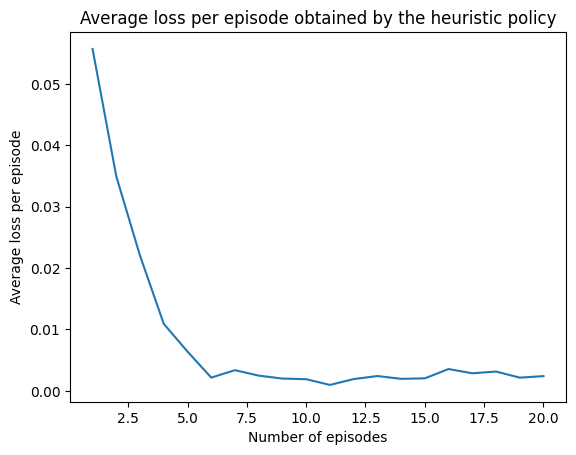

In [43]:
# Write a loop in which the HeuristicPendulumAgent collects experience and stores it in the replay
# buffer. At each step, sample a batch of transitions from the replay buffer (uniformly at random,
# batch size 128) and feed them to the 1-step TD-learning rule that you have implemented. At each
# step, store the loss of the Q network. 
import copy
env = gym.make("Pendulum-v1")
num_episode=20
batch_size=128
buffer_size=10000
gamma=0.99
learning_rate=1e-4
sum_loss=0
list_average_loss=[]
# initialize the Q network 
Q_network=QNetwork()
# Q_target=QNetwork()
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = HeuristicPendulumAgent(env)
num_step=200

state, info = env.reset()
for _ in range(buffer_size):
    action = agent.compute_action(state,fix_torque)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    next_state, reward, terminated, truncated, info = env.step(normalized_action)
    transition=(state, normalized_action, reward, next_state, truncated)
    replay_buffer.add(transition)
    state=next_state

for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    # renw the environment for every episode
    state, info = env.reset()
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        ## Todo: check with TA wether put also Q_network to target network ???
        loss=train(Q_network, Q_network,agent, replay_buffer, gamma, optimizer, batch_size)
        # print('loss:',loss)
        # Q_target=copy.deepcopy(Q_network)
        sum_loss=+loss

        # add transition to replay buffer, and kick out the old one if the buffer is full
        action = agent.compute_action(state,fix_torque)
        # print('action:',action)
        normalized_env = NormalizedEnv(env)
        normalized_action = normalized_env.action(action)
        # print('normalized_action:',normalized_action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

    average_loss=sum_loss/num_step
    list_average_loss.append(average_loss)
print('Finishing training!')
print('Save the model...')
# save the model with path name with real-time date and time
save_path= os.path.join('trained_model','Q_network_heuristic_policy_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
# torch.save(Q_network.state_dict(), save_path)
print('Model save to ',save_path,' !')

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_average_loss)
plt.xlabel('Number of episodes')
plt.ylabel('Average loss per episode')
plt.title('Average loss per episode obtained by the heuristic policy')
print('Save the figure...')
image_path=os.path.join('figure','4_TrainingCruveofQnetwork__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
# plt.savefig(image_path)
plt.show()
env.close()


In [11]:
Q_network=QNetwork()
state, info = env.reset()
for _ in range(buffer_size):
    action = agent.compute_action(observation,fix_torque)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    next_state, reward, terminated, truncated, info = env.step(normalized_action)
    transition=(state, normalized_action, reward, next_state, truncated)
    replay_buffer.add(transition)
    state=next_state
    
# sample a batch of transitions from the replay buffer
batch = replay_buffer.sample(batch_size)
 # unpack the batch of transitions
# input_batch:put together 3 elements of the state and 1 of the action
input_batch=torch.tensor([np.append(transition[0],transition[1]) for transition in batch], dtype=torch.float32)

# compute the Q values of the current state + action pair
Q_values = Q_network(input_batch)



The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buffer is full.-> remove the oldest transition
The replay buf

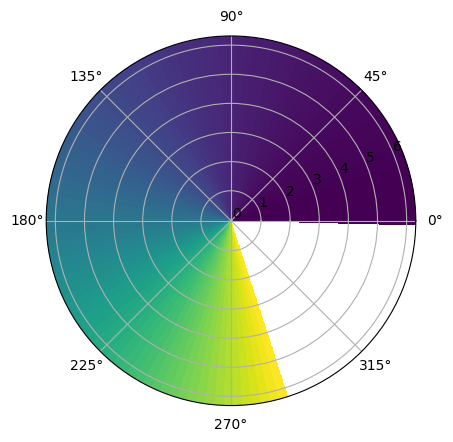

In [12]:
ax = Axes3D(plt.figure())
rad=np.linspace(0,5,100)
azm=np.linspace(0,2*np.pi,100)
r,th=np.meshgrid(rad,azm)
z=(r**2.0)/4.0
plt.subplot(projection="polar")
plt.pcolormesh(r,th, z)
plt.show()